In [2]:
%pylab inline
plt.style.use('../tweezepy.mplstyle')
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


## Robust Uncertainties

In most cases, the Hessian method is sufficient for calculating the parameter uncertainties. However, in some cases (e.g., small sample sizes and parasitic noise), the Gaussian approximation for the parameter erros is not valid. In these cases, it may be necessary to run a Monte Carlo sampler to estimate errors. This method is slower but more robust.


### Simulate trace
First, we'll simulate a downsampled example trace. 

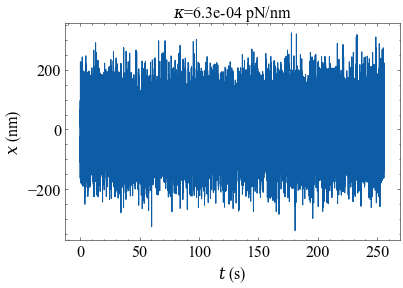

In [4]:
from tweezepy import downsampled_trace, PSD, AV
fc = 10 # corner frequency
gamma = 1e-5 # dissipation due to viscous drag, in pN s/nm
             # 1e-5 is a typical value for an MT experiment
kappa = gamma*2*np.pi*fc # kappa in pN/nm
fsample = 400 # sampling frequency in Hz
N  = 102400 # number of points in trajectory
seed = 0 # random seed for reproducibility
time = np.arange(N)/fsample
xtrace_ds = downsampled_trace(gamma,kappa,fsample,N, seed = seed)
plt.plot(time, xtrace_ds)
plt.xlabel('$t$ (s)')
plt.ylabel('$x$ (nm)')
plt.title(r'$\kappa$=%.1e pN/nm'%kappa)
plt.show()

### Calculate PSD
Now, we'll calculate the experimental AV and fit it.

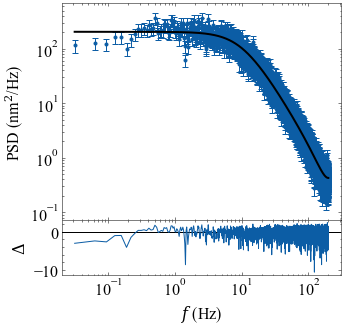

In [6]:
psd = PSD(xtrace_ds,fsample,bins = 15)
psd.mlefit()
psd.plot();

### Monte Carlo sampling
Now, that we have an MLE fit, we can use the emcee package to perform Monte Carlo sampling of the parameter space.

100%|██████████| 2000/2000 [01:13<00:00, 27.07it/s]


(<Figure size 720x432 with 2 Axes>,
 [<AxesSubplot:ylabel='$\\gamma$ (pNs/nm)'>,
  <AxesSubplot:xlabel='step number', ylabel='$\\kappa$ (pN/nm)'>])

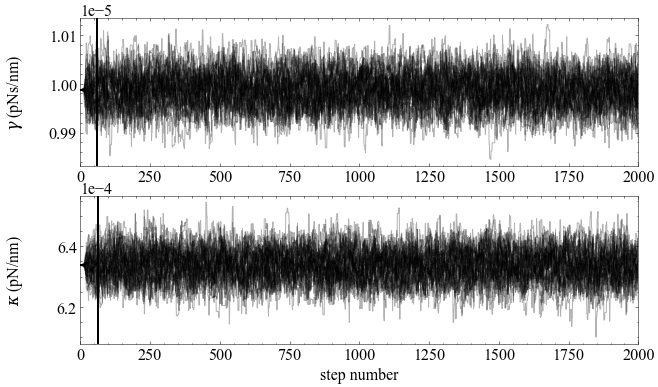

In [8]:
psd.mcmc()
psd.sample_plot(labels=[r"$\gamma$ (pNs/nm)",r"$\kappa$ (pN/nm)"])

This plot shows the accepted step from the Monte Carlo sampling. It takes the sampler some time to 'forget' the initial state, so we'll throw out twice the autocorrelation time (black vertical line). Then, we'll thin the samples by half the autocorrelation time to ensure the steps are uncorrelated. 

(<Figure size 720x432 with 2 Axes>,
 [<AxesSubplot:ylabel='g'>, <AxesSubplot:xlabel='step number', ylabel='k'>])

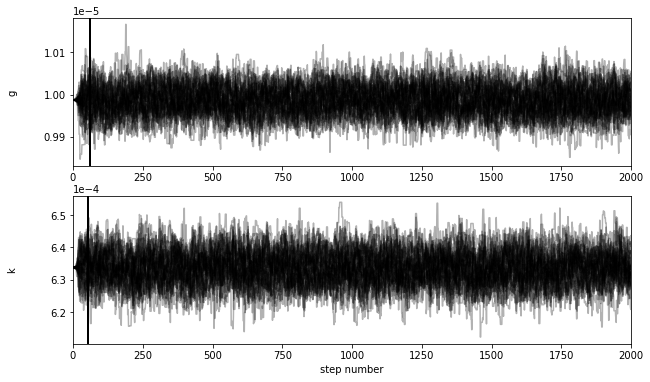

In [14]:
psd.sample_plot()

We can use a corner plot to look at the 1 and 2D histograms. This uses the corner package, which is separate from the emcee package. The MLE best-fit parameter estimates are indicated by the blue lines. The dotted black lines in the 1D histograms are the 16th and 84th% percentiles. The black lines in the 2D histogram are the 1,2, and 3 standard deviations.

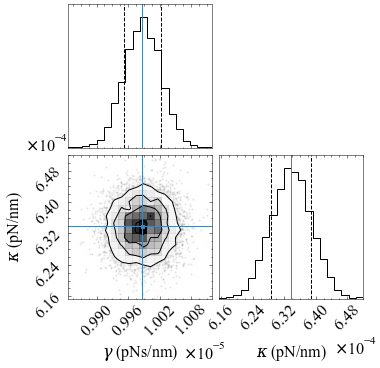

In [10]:
psd.corner_plot(labels=[r"$\gamma$ (pNs/nm)",r"$\kappa$ (pN/nm)"]);

In [11]:
# The mcmc results are automatically added to the results dictionary
psd.results

{'chi2': 9541.523752905014,
 'redchi2': 1.4915622561990016,
 'g': 9.987274585927754e-06,
 'g_error': 4.939065221213263e-08,
 'k': 0.0006338066057220219,
 'k_error': 7.270886693644723e-06,
 'support': 1.0,
 'p-value': 0.0,
 'AIC': 13644.000903245327,
 'g_mcmc': 9.987417704837286e-06,
 'g_mcmc_error': 3.477148658851021e-08,
 'k_mcmc': 0.0006337909875973476,
 'k_mcmc_error': 5.164586781813941e-06}

In [12]:
# We can also access the mcmc median and standard error values
print(psd.mcmc_params)
print(psd.mcmc_std_errors)

[9.98741770e-06 6.33790988e-04]
[3.47714866e-08 5.16458678e-06]
